# Wealth transfer

This notebook presents a tutorial for beginners on how to create a simple agent-based model with the [agentpy](https://agentpy.readthedocs.io) package. 
It demonstrates how to create a basic model with a custom agent type, run a simulation, record data, and visualize results.

In [1]:
# Model design
import agentpy as ap
import numpy as np 

# Visualization
import seaborn as sns

## About the model

The model explores the distribution of wealth under a trading population of agents. 
Each agent starts with one unit of wealth. 
During each time-step, each agents with positive wealth 
randomly selects a trading partner and gives them one unit of their wealth.
We will see that this random interaction will create an inequality of wealth that 
follows a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).
The original version of this model been written in [MESA](https://mesa.readthedocs.io/) 
and can be found [here](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html).

## Model definition

We start by defining a new type of `Agent` with the following methods:

- `setup()` is called automatically when a new agent is created and initializes a variable `wealth`.
- `wealth_transfer()` describes the agent's behavior at every time-step and will be called by the model.

In [2]:
class WealthAgent(ap.Agent):

    """ An agent with wealth """

    def setup(self):

        self.wealth = 1

    def wealth_transfer(self):

        if self.wealth > 0:

            partner = self.model.agents.random()
            partner.wealth += 1
            self.wealth -= 1

Next, we define a method to calculate the [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), 
which will measure the inequality among our agents.

In [3]:
def gini(x):

    """ Calculate Gini Coefficient """
    # By Warren Weckesser https://stackoverflow.com/a/39513799
    
    x = np.array(x)
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad 

Finally, we define our [`Model`](https://agentpy.readthedocs.io/en/stable/reference_models.html) with the following methods:

- `setup` defines how many agents should be created at the beginning of the simulation. 
- `step` calls all agents during each time-step to perform their `wealth_transfer` method. 
- `update` calculates and record the current Gini coefficient after each time-step. 
- `end`, which is called at the end of the simulation, we record the wealth of each agent.

In [4]:
class WealthModel(ap.Model):

    """ A simple model of random wealth transfers """

    def setup(self):

        self.agents = ap.AgentList(self, self.p.agents, WealthAgent)

    def step(self):

        self.agents.wealth_transfer()

    def update(self):

        self.record('Gini Coefficient', gini(self.agents.wealth))

    def end(self):

        self.agents.record('wealth')

## Simulation run

To prepare, we define parameter dictionary with a [random seed](https://agentpy.readthedocs.io/en/stable/guide_random.html), the number of agents, and the number of time-steps.

In [5]:
parameters = {
    'agents': 100,
    'steps': 100,
    'seed': 42,
}

To perform a simulation, we initialize our model with a given set of parameters and call [`Model.run()`](https://agentpy.readthedocs.io/en/stable/reference_models.html).

In [6]:
model = WealthModel(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.115889
Simulation finished


## Output analysis

The simulation returns a [`DataDict`](https://agentpy.readthedocs.io/en/stable/reference_output.html) with our recorded variables.

In [7]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 3 keys
'variables': 
    'WealthModel': DataFrame with 1 variable and 101 rows
    'WealthAgent': DataFrame with 1 variable and 100 rows
}

The output's `info` provides general information about the simulation.

In [8]:
results.info

{'model_type': 'WealthModel',
 'time_stamp': '2021-05-13 11:34:54',
 'agentpy_version': '0.0.7',
 'python_version': '3.8.5',
 'experiment': False,
 'completed': True,
 'created_objects': 100,
 'completed_steps': 100,
 'run_time': '0:00:00.115889'}

To explore the evolution of inequality,
we look at the recorded [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the model's variables.

In [9]:
results.variables.WealthModel.head()

,Gini Coefficient
t,
0,0.0000
1,0.5370
2,0.5690
3,0.5614
4,0.5794


To visualize this data, 
we can use [`DataFrame.plot`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html).

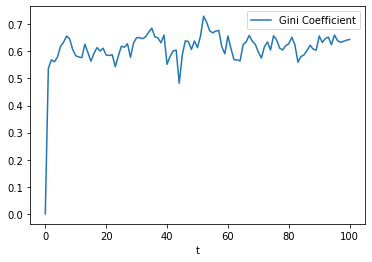

In [10]:
data = results.variables.WealthModel
ax = data.plot()

To look at the distribution at the end of the simulation, 
we visualize the recorded agent variables with [seaborn](https://seaborn.pydata.org/).

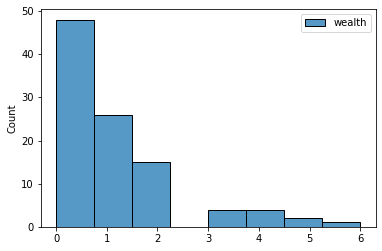

In [11]:
sns.histplot(data=results.variables.WealthAgent);

The result resembles a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).